# Final projection exploration notebook

Dataset: https://www.kaggle.com/datasets/crawford/cat-dataset/data, Oct 9 2024, 11:05am

"super small projects"

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from C4_helper import DataLoader, get_bbox, grabcut_algorithm, get_ROIs

# data_dir = './cats/'
# cut_img_file = 'grabCut_np_imgs.npy'

toy_dir = './cats/CAT_00'
toy_cuts = 'grabCut_toy.npy'

# Object detection
Goal for object detection with bboxes
Simplyfying assumption: No other animals than cats, 1 animal at a time


In [2]:
data = DataLoader(toy_dir)
#print('Amount of cat img files in source dir:', len(data.train))
if os.path.isfile(toy_cuts):
    img_ROIs = np.load(toy_cuts)
else:
    img_ROIs = get_ROIs(data.imgs)  # currently skips images with no bbox (131/7997)

    if toy_cuts:
        np.save(toy_cuts, img_ROIs)

print('Amount of image-ROIs to work with:', len(img_ROIs))

Amount of image-ROIs to work with: 87


In [3]:
def show_example(fname):
    og_img = Image.open(fname).resize((250,250))
    bbox_img, bbox = get_bbox(fname)
    cut_img = grabcut_algorithm(fname, bbox[0])
    figure, axis = plt.subplots(1, 3)

    for i, img in enumerate([og_img, bbox_img, cut_img]):
        axis[i].imshow(img, interpolation='nearest')
    plt.show()

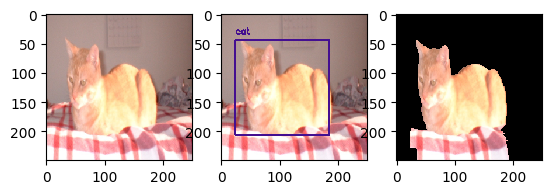

In [11]:
show_example(data.imgs[18])

refine to: face, body, paws, tail?

In [5]:
# lit:
# https://pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/, big overview
# Faster R-CNN paper: https://arxiv.org/abs/1506.01497
# faster r-cnn in pytorch: http://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn


# Unsupervised clustering

In [48]:
# normalise values
# oct 21, 16:32
#https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
import sklearn

flat_ROIs = list()
for img_arr in img_ROIs:
    flat_ROIs.append(img_arr.flatten())
flat_ROIs = np.array(flat_ROIs, dtype=np.float32)
flat_ROIs /= 255
#flat_ROIs = KMeans.fit_transform(flat_ROIs)

In [49]:
img_ROIs.shape, flat_ROIs.shape

((87, 250, 250, 3), (87, 187500))

In [50]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0)
Y = kmeans.fit_predict(flat_ROIs)

print(Y)

[2 2 3 0 1 1 0 1 3 3 1 2 1 1 1 0 3 0 1 3 2 1 3 4 1 2 2 2 3 2 1 0 3 0 2 2 1
 1 4 3 1 4 4 3 3 2 2 3 2 1 4 3 1 3 4 3 1 1 1 1 3 1 2 4 0 3 2 3 3 4 1 2 1 1
 3 2 2 1 1 1 3 3 1 1 2 2 1]


In [53]:
clusters = {cluster_id : list() for cluster_id in set(Y)}
for i, cluster_id in enumerate(Y):
    clusters[cluster_id].append(img_ROIs[i])

In [56]:
[len(clusters[id]) for id in set(Y)]

[7, 30, 20, 22, 8]

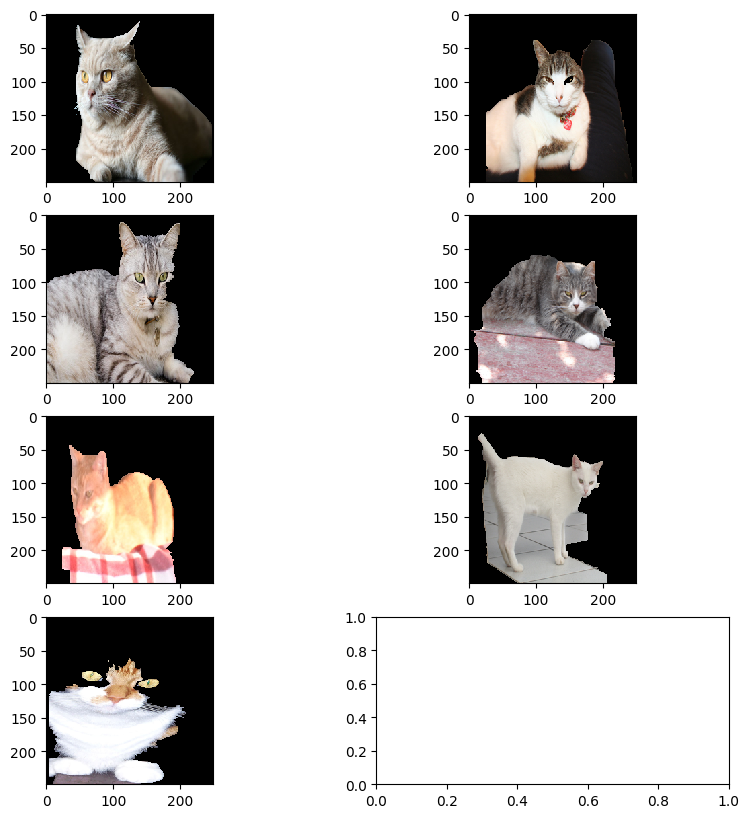

In [82]:
figure, axis = plt.subplots(4, 2)
figure.set_figwidth(10)
figure.set_figheight(10)

for i, img in enumerate(clusters[0]):
    if i < (len(clusters[0])/2):
        axis[i][0].imshow(img, interpolation='nearest')
    else:
        axis[i-4][1].imshow(img, interpolation='nearest')

plt.show()

In [8]:
# ?? use ggplot in r 
# on clustering https://www.geeksforgeeks.org/clustering-in-machine-learning/

# project https://www.trpkovski.com/2023/10/23/grouping-images-by-colours-exploring-colour-based-image-clustering

In [9]:
# features: max pooling for darkest & lightest areas, also mean colour
# normalise with cnn first to reduce noise, also adjust for lighting
# later adapt if u use different region?

In [10]:
# code example?
# https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
